In [1]:
import os
import tensorflow as tf
from roboflow import Roboflow
from dotenv import load_dotenv
load_dotenv("labelbox.env")

True

In [ ]:
print(tf.version.VERSION)

# - Load Data

---

### --- Load Labelbox Project

In [113]:
import labelbox
LB_API_KEY = os.getenv("labelbox_soccer")
PROJECT_ID = 'clgmw7co50urt070y3evv6o23'
client = labelbox.Client(api_key = LB_API_KEY)
project = client.get_project(PROJECT_ID)
labels = project.export_v2(params={
"data_row_details": True,
"metadata": True,
"attachments": True,
"project_details": True,
"performance_details": True,
"label_details": True,
"interpolated_frames": True
  })

In [117]:
export_json = labels.result
# print("results: ", export_json)

In [147]:
export_json[0]['data_row']

{'id': 'clgmwa5j704190782cyw4fc40',
 'external_id': '480.jpg',
 'row_data': 'https://storage.labelbox.com/clglp66ge0ec0073pdy6733hi%2F69a9b4a0-3489-6279-61a4-6164bb7cc467-480.jpg?Expires=1685327776549&KeyName=labelbox-assets-key-3&Signature=TEPiJLeok-Hk3-Fjq1Y5My9-Th4',
 'details': {'dataset_id': 'clgmw93uh1rx5070dc90lgdp9',
  'created_at': '2023-04-18T23:27:20.000+00:00',
  'updated_at': '2023-04-18T23:27:20.000+00:00',
  'last_activity_at': '2023-04-20T17:09:19.943+00:00',
  'created_by': 'yying2@alumni.cmu.edu'}}

In [140]:
export_json[0]['projects']['clgmw7co50urt070y3evv6o23']['labels'][0]['annotations']['classifications']

[{'feature_id': 'clgmwf9sb001z356j3qcucpb9',
  'name': 'Sideline',
  'radio_answer': {'feature_id': 'clgmwf9sb001y356j5zc1qips',
   'name': 'Yes',
   'classifications': []}}]

### --- Load Roboflow Project with image annotation data

In [2]:
RF_KEY = os.getenv("rb_key")
rf = Roboflow(api_key=RF_KEY)
project = rf.workspace("personal-y96vs").project("soccer-object-detection-yj7hm")
# dataset = project.version(1).download("tensorflow")

loading Roboflow workspace...
loading Roboflow project...


In [3]:
# dataset.location = r"C:\Users\yingy\Desktop\Py_personal\Learning\soccer\tf_object_detection\Soccer Object detection.v1i.tfrecord_ignore_data"
# LOCATION = dataset.location
LOCATION = r"C:\Users\yingy\Desktop\Py_personal\Learning\soccer\tf_object_detection\Soccer Object detection.v1i.tfrecord_ignore_data"
print("location:", LOCATION)
CLASSES = sorted(project.classes.keys())
print("classes:", CLASSES)

location: C:\Users\yingy\Desktop\Py_personal\Learning\soccer\tf_object_detection\Soccer Object detection.v1i.tfrecord_ignore_data
classes: ['ball', 'field_line', 'goal', 'keeper', 'player', 'ref', 'score', 'time']


In [4]:
# test_record_fname = dataset.location + '/test/cells.tfrecord'
train_record_fname = LOCATION + '/train/people.tfrecord'
label_map_pbtxt_fname = LOCATION + '/train/people_label_map.pbtxt'

In [5]:
raw_dataset = tf.data.TFRecordDataset(train_record_fname)

In [111]:
for raw_record in raw_dataset.take(1):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
#     print(example.features.feature)
    print(example)

features {
  feature {
    key: "image/encoded"
    value {
      bytes_list {
        value: "\377\330\377\340\000\020JFIF\000\001\001\000\000\001\000\001\000\000\377\333\000C\000\010\006\006\007\006\005\010\007\007\007\t\t\010\n\014\024\r\014\013\013\014\031\022\023\017\024\035\032\037\036\035\032\034\034 $.\' \",#\034\034(7),01444\037\'9=82<.342\377\333\000C\001\t\t\t\014\013\014\030\r\r\0302!\034!22222222222222222222222222222222222222222222222222\377\300\000\021\010\002\200\002\200\003\001\"\000\002\021\001\003\021\001\377\304\000\037\000\000\001\005\001\001\001\001\001\001\000\000\000\000\000\000\000\000\001\002\003\004\005\006\007\010\t\n\013\377\304\000\265\020\000\002\001\003\003\002\004\003\005\005\004\004\000\000\001}\001\002\003\000\004\021\005\022!1A\006\023Qa\007\"q\0242\201\221\241\010#B\261\301\025R\321\360$3br\202\t\n\026\027\030\031\032%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\203\204\205\206\207\210\211\212\222\223\224\225\226\227\230\231\232\242\243\244\245\246\

# - Plot an image with label

---
Reference: 
https://www.kaggle.com/code/mistag/tensorflow-tfrecords-demystified

In [151]:
img_example = next(iter(raw_dataset)) 
img_parsed = tf.train.Example.FromString(img_example.numpy())
# only extract features we will actually use
xmin=img_parsed.features.feature['image/object/bbox/xmin'].float_list.value[:]
xmax=img_parsed.features.feature['image/object/bbox/xmax'].float_list.value[:]
ymin=img_parsed.features.feature['image/object/bbox/ymin'].float_list.value[:]
ymax=img_parsed.features.feature['image/object/bbox/ymax'].float_list.value[:]
file_name=img_parsed.features.feature['image/filename'].bytes_list.value[0].decode()
classes=img_parsed.features.feature['image/object/class/text'].bytes_list.value[:]
class_label=img_parsed.features.feature['image/object/class/label'].int64_list.value[:]
img_encoded=img_parsed.features.feature['image/encoded'].bytes_list.value[0]

In [152]:
file_name

'610_jpg.rf.05d90c0846e9711106eedc476d2bcea7.jpg'

In [100]:
def bbox(img, xmin, ymin, xmax, ymax, width, label, score):
    draw = ImageDraw.Draw(img)
    xres, yres = img.size[0], img.size[1]
    box = np.multiply([xmin, ymin, xmax, ymax], [xres, yres, xres, yres]).astype(int).tolist()
    txt = " {}: {}%" if score >= 0. else " {}"
    txt = txt.format(label, round(score, 1))
    ts = draw.textbbox((len(txt)*6,8), txt)
    draw.rectangle(box, width=width)
    if len(label) > 0:
        if box[1] >= ts[1]+3:
            xsmin, ysmin = box[0], box[1]-ts[1]-3
            xsmax, ysmax = box[0]+ts[0]+2, box[1]
        else:
            xsmin, ysmin = box[0], box[3]
            xsmax, ysmax = box[0]+ts[0]+2, box[3]+ts[1]+1
        draw.rectangle([xsmin, ysmin, xsmax, ysmax],width = 1)
        draw.text((xsmin, ysmin), txt, fill='white')

def plot_img(img, axes, xmin, ymin, xmax, ymax, classes, class_label):
    for i in range(len(xmin)):
        bbox(img, xmin[i], ymin[i], xmax[i], ymax[i], 2, classes[i].decode(), -1)
    plt.setp(axes, xticks=[], yticks=[])
    plt.imshow(img)

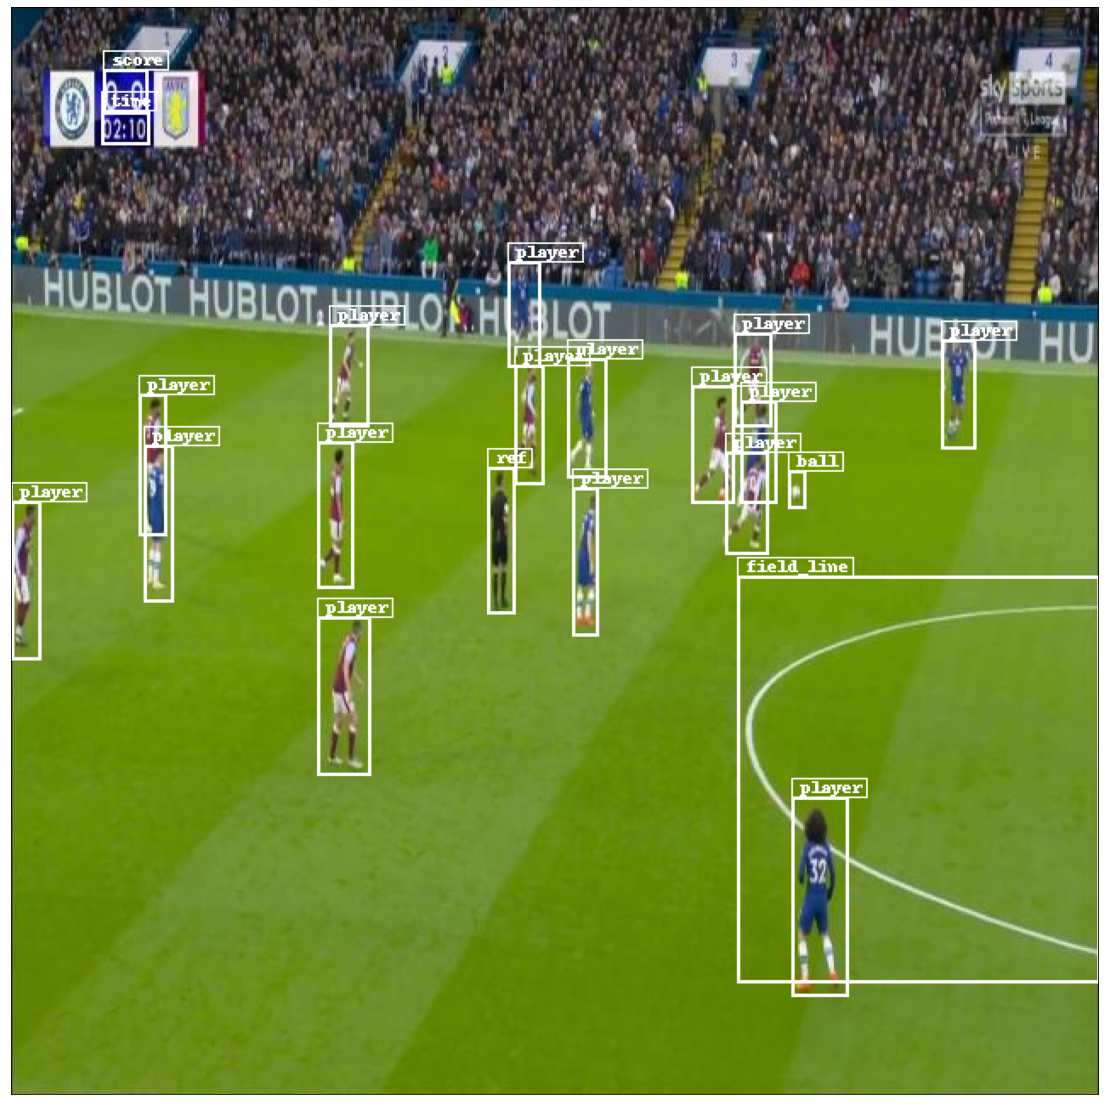

In [101]:
import numpy as np
from io import BytesIO
from PIL import Image, ImageFont, ImageDraw
fig = plt.figure(figsize=(20,20))
axes = axes = fig.add_subplot(1, 1, 1)
img = Image.open(BytesIO(img_encoded))
plot_img(img, axes, xmin, ymin, xmax, ymax, classes, class_label)

In [13]:
# Create a dictionary describing the features.
image_feature_description = {
    'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/ymin':  tf.io.VarLenFeature( tf.float32),
    'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
    'image/object/class/label': tf.io.VarLenFeature(tf.int64),
    'image/format': tf.io.FixedLenFeature([], tf.string),
    'image/height': tf.io.FixedLenFeature([], tf.int64),
    'image/width': tf.io.FixedLenFeature([], tf.int64),
    'image/filename': tf.io.VarLenFeature(tf.string),
    'image/object/class/text': tf.io.VarLenFeature(tf.string),
    'image/encoded': tf.io.FixedLenFeature([], tf.string),
}

def _parse_image_function(example_proto):
  # Parse the input tf.train.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, image_feature_description)

parsed_image_dataset = raw_dataset.map(_parse_image_function)
parsed_image_dataset

<MapDataset element_spec={'image/filename': SparseTensorSpec(TensorShape([None]), tf.string), 'image/object/bbox/xmax': SparseTensorSpec(TensorShape([None]), tf.float32), 'image/object/bbox/xmin': SparseTensorSpec(TensorShape([None]), tf.float32), 'image/object/bbox/ymax': SparseTensorSpec(TensorShape([None]), tf.float32), 'image/object/bbox/ymin': SparseTensorSpec(TensorShape([None]), tf.float32), 'image/object/class/label': SparseTensorSpec(TensorShape([None]), tf.int64), 'image/object/class/text': SparseTensorSpec(TensorShape([None]), tf.string), 'image/encoded': TensorSpec(shape=(), dtype=tf.string, name=None), 'image/format': TensorSpec(shape=(), dtype=tf.string, name=None), 'image/height': TensorSpec(shape=(), dtype=tf.int64, name=None), 'image/width': TensorSpec(shape=(), dtype=tf.int64, name=None)}>

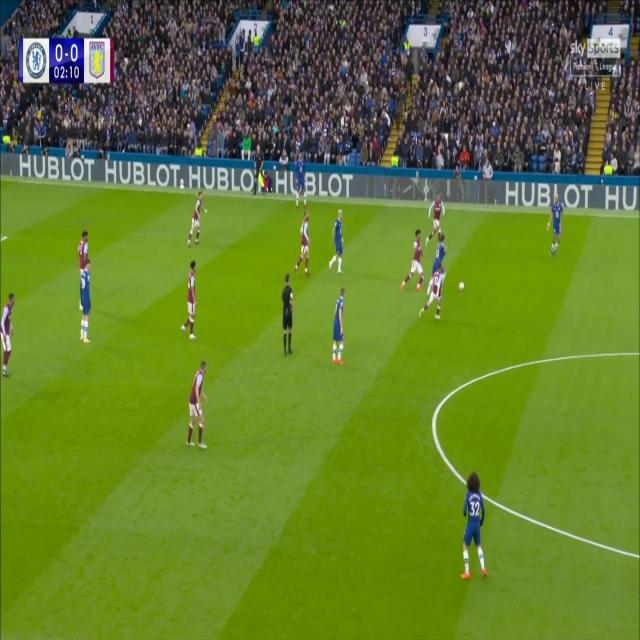

In [58]:
import IPython.display as display
for image_features in parsed_image_dataset.take(1):
    image_raw = image_features['image/encoded'].numpy()
    display.display(display.Image(data=image_raw))

In [ ]:
for i, raw_record in enumerate(raw_dataset.take(1)):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    info = {}
    info['image/encoded'] = example.features.feature['image/encoded'].bytes_list.value[0]

In [ ]:
import io
from PIL import Image

imageStream = io.BytesIO(info['image/encoded'])
imageFile = Image.open(imageStream)
display(imageFile)

# References

https://www.tensorflow.org/guide/data#consuming_tfrecord_data

[How to Train YOLO-NAS on a Custom Dataset](https://blog.roboflow.com/yolo-nas-how-to-train-on-custom-dataset/): [Notebook](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/train-yolo-nas-on-custom-dataset.ipynb?ref=blog.roboflow.com#scrollTo=sGBOHyPc11LA)

[Read tfrecord dataset for images](https://www.tensorflow.org/tutorials/load_data/tfrecord)